This is a complicated food image classifier. In order to increase the classification accuracy, I will use many preprocessing and data augmentation methods.

# 0. Download the food images

In [1]:
!git clone https://github.com/Albert-Aiqi-Zhang/Food-Image-Classifier datasets

Cloning into 'datasets'...
remote: Enumerating objects: 1857, done.
remote: Total 1857 (delta 0), reused 0 (delta 0), pack-reused 1857
Receiving objects: 100% (1857/1857), 269.24 MiB | 36.37 MiB/s, done.
Resolving deltas: 100% (40/40), done.


# 1. Preprocessing

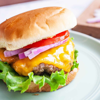

In [2]:
from PIL import Image
from numpy import asarray
import numpy as np
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import PIL
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42

dataset_root_dir = "/content/datasets/food_datasets"
dataset = datasets.ImageFolder(root=dataset_root_dir)

image = Image.open("datasets/food_datasets/1/1.png")
image

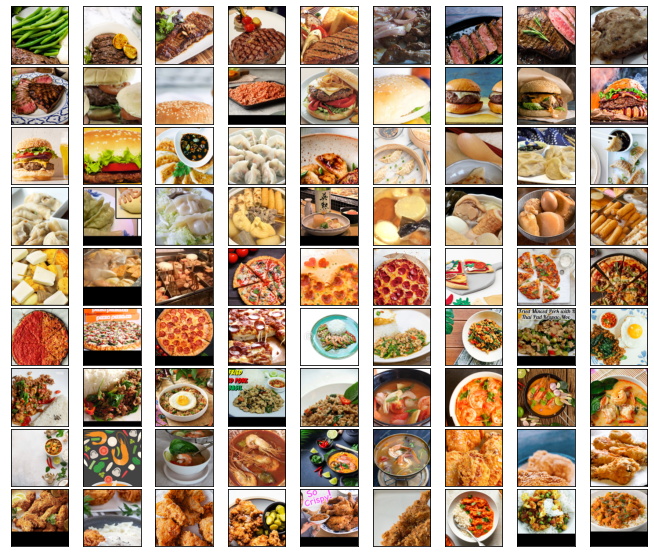

In [3]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  plt.imshow(dataset[i * 10][0])

### 1.1  Global Contrast Normalization (GCN)

In [337]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

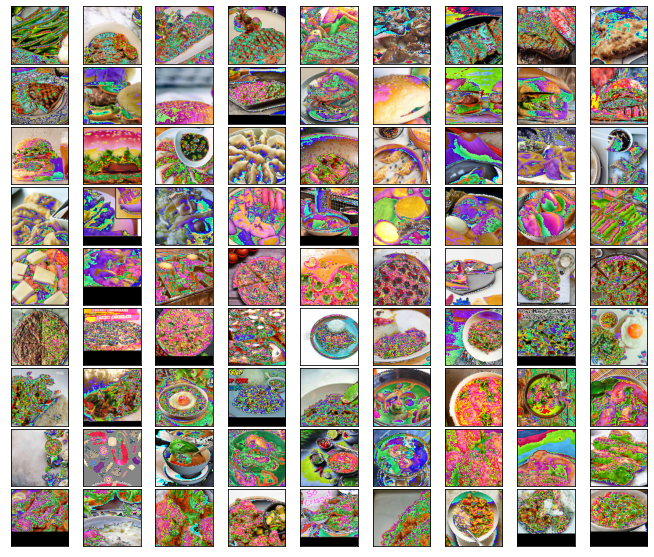

In [338]:
mean = (0,)
std = (0.5,)
images_GCN = datasets.ImageFolder(dataset_root_dir, transform = ImageTransform(mean, std))

# IMAGE_SIZE = 975
# data_transform = transforms.Compose([
#                     transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.08, 1.0), interpolation=PIL.Image.BILINEAR),
#                     transforms.CenterCrop(IMAGE_SIZE)
# ])

# dataset_GCN = datasets.ImageFolder(root=dataset_root_dir, transform=data_transform)


fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  img_pil = transforms.ToPILImage(mode='RGB')(images_GCN[i * 10][0])
  plt.imshow(img_pil)

In [376]:
### Correct labels for all food images
labelNums = [96, 99, 98, 95, 96, 100, 98, 97, 97, 99]
y_labels = []
for i, labelNum in enumerate(labelNums):
  for j in range(labelNum):
    y_labels.append(i)

# merge data and labels
data_with_labels = []
data_without_labels = []
# for idx in range(len(images_GCN)):
for idx in range(len(images_GCN)):
  foodImage = images_GCN[idx][0]
  # numpy_image = np.asarray(foodImage)[:95:3, :95:3, :].transpose(2, 1, 0)
  # numpy_image = np.asarray(foodImage).transpose(2, 1, 0)
  # numpy_image = np.asarray(foodImage)
  # tensor_image = torch.from_numpy(numpy_image.astype(np.float32)).clone()
  # data_with_labels.append([tensor_image, y_labels[idx]])
  # data_without_labels.append(tensor_image)
  data_with_labels.append([foodImage, y_labels[idx]])

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### 1.2. ZCA whitening

In [7]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 100 == 0:
                print("{0}/{1}".format(i, len(images)))
        self.E, self.V = torch.symeig(con_matrix, eigenvectors=True)  # 固有値分解
        self.E = torch.max(self.E, torch.zeros_like(self.E)) # 誤差の影響で負になるのを防ぐ
        self.ZCA_matrix = torch.mm(torch.mm(self.V, torch.diag((self.E.squeeze()+self.epsilon)**(-0.5))), self.V.t())
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

Mention that here the RAM is not enough if I use the initial 100 * 100 images,
so I have to resize the image, cutting it to a quarter.

In [390]:
zca = ZCAWhitening()
zca.fit(data_with_labels)

### 1.3 split training, validation and test data

In [377]:
# training data: 65%
# validation data: 10%
# test data: 25%
total_length = len(data_with_labels)
length_trainAndValid = int(total_length * 0.75)
length_test = total_length - length_trainAndValid
length_train = int(total_length * 0.65)
length_valid = length_trainAndValid - length_train
trainAndValid_dataset, test_dataset = torch.utils.data.random_split(data_with_labels, [length_trainAndValid, length_test])
train_dataset, valid_dataset = torch.utils.data.random_split(trainAndValid_dataset, [length_train, length_valid])

In [378]:
# We need to transform training data, so I have to transpose the tensor to
# the initial size first.
train_dataset_initial = []
for imageTensor, label in train_dataset:
  # imageTensor = imageTensor.to('cpu').detach().numpy().copy().transpose(2, 1, 0)
  # imageTensor = imageTensor.to('cpu').detach().numpy().copy()
  # imageTensor = torch.from_numpy(imageTensor.astype(np.float32)).clone()
  train_dataset_initial.append([imageTensor, label])

In [43]:
len(train_dataset)

633

In [342]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        #csvファイル読み込み。
        # df = pd.read_csv(csv_path)
        # image_paths = df['path']
        # labels = df['label']

        self.data = [imageArray for imageArray, label in data]
        self.labels = [label for imageArray, label in data]
        self.transform = transform


    def __getitem__(self, index):
        image_data = self.data[index] 
        
        # img = transforms.ToPILImage(mode='RGB')(image_data)

        #transform事前処理実施
        if self.transform is not None:
            image_data = self.transform(image_data)

        label = self.labels[index]
        return [image_data, label]

    def __len__(self):
        #データ数を返す
        return len(self.data)

## 2. Data Augmentation
### 2.1. Random Resize Cropping

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


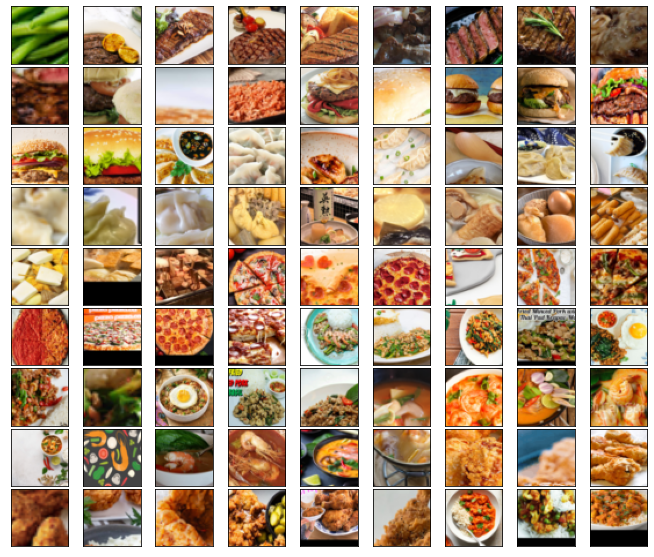

In [80]:
IMAGE_SIZE = 50
data_transform = transforms.Compose([
                    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.08, 1.0), interpolation=PIL.Image.BILINEAR),
                    transforms.CenterCrop(IMAGE_SIZE)
])

dataset_randomResizeCrop = datasets.ImageFolder(root=dataset_root_dir, transform=data_transform)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  plt.imshow(dataset_randomResizeCrop[i * 10][0])

In [379]:
IMAGE_SIZE = 100
# TRAIN_SIZE = 100
data_transform = transforms.Compose([
                    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.08, 1.0), interpolation=PIL.Image.BILINEAR),
                    transforms.CenterCrop(IMAGE_SIZE)
])

train_dataset_randomResizeCrop = MyDataset(train_dataset_initial, data_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


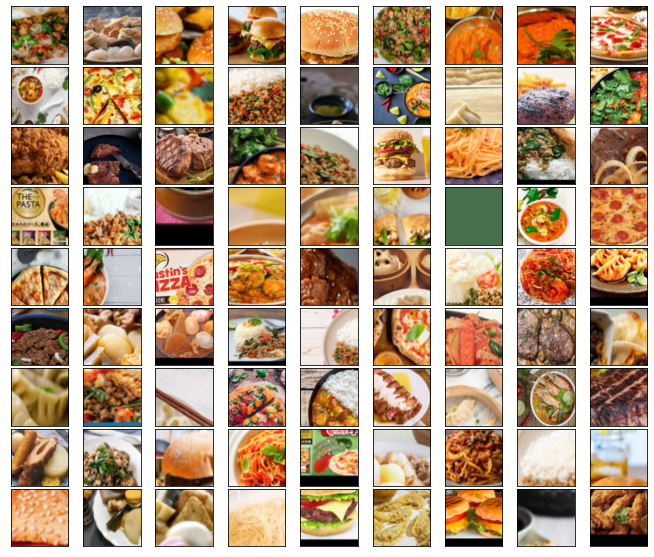

In [318]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  img_pil = transforms.ToPILImage(mode='RGB')(train_dataset_randomResizeCrop[i * 6][0])
  plt.imshow(img_pil)

### 2.2. Random Cropping and Padding

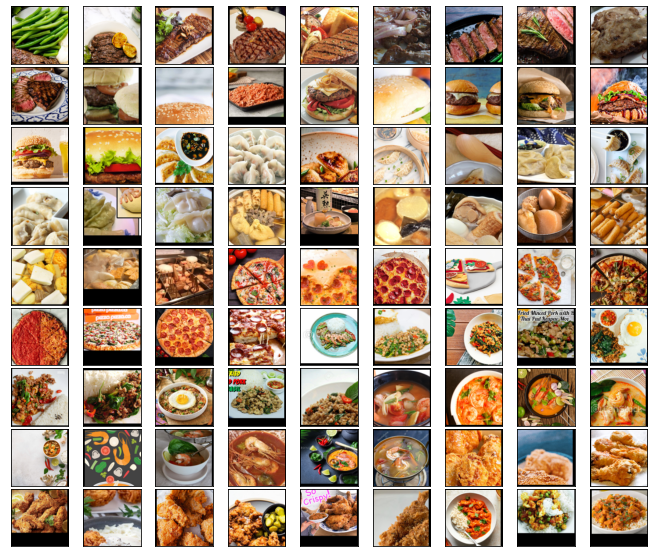

In [89]:
data_transform = transforms.Compose([transforms.RandomCrop(100, padding=(4, 4, 4, 4), padding_mode='constant')])

dataset_randomResizeCropPadding = datasets.ImageFolder(root=dataset_root_dir, transform=data_transform)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  plt.imshow(dataset_randomResizeCropPadding[i * 10][0])

In [380]:
data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(4, 4, 4, 4), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingOne = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(6, 6, 6, 6), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingTwo = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(10, 10, 10, 10), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingThree = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(15, 15, 15, 15), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingFour = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(20, 20, 20, 20), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingFive = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(30, 30, 30, 30), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingSix = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(8, 8, 8, 8), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingSeven = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomCrop(100, padding=(12, 12, 12, 12), padding_mode='constant')
])
train_dataset_randomResizeCropPaddingEight = MyDataset(train_dataset_initial, data_transform)


### 2.3. Horizontal Flip

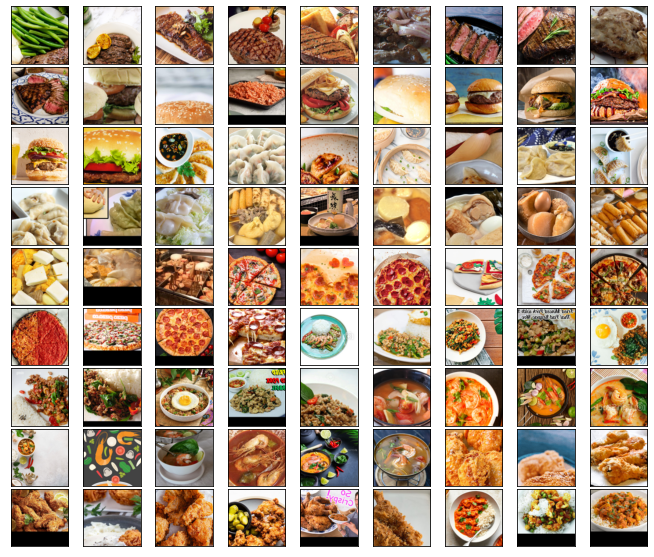

In [76]:
data_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=1.0)
])

dataset_horizontalFlip = datasets.ImageFolder(root=dataset_root_dir, transform=data_transform)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  plt.imshow(dataset_horizontalFlip[i * 10][0])

In [369]:
data_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=1.0)
])

train_dataset_horizontalFlip = MyDataset(train_dataset_initial, data_transform)

data_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=1.0),
                    transforms.RandomCrop(100, padding=(10, 10, 10, 10), padding_mode='constant')
])

train_dataset_horizontalFlipCrop = MyDataset(train_dataset_initial, data_transform)

### 2.4. Vertical Flip

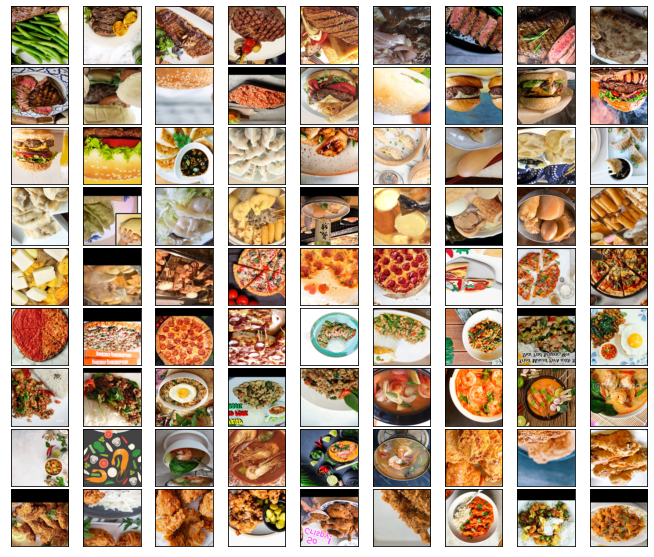

In [79]:
data_transform = transforms.Compose([
                    transforms.RandomVerticalFlip(p=1.0)
])

dataset_verticalFlip = datasets.ImageFolder(root=dataset_root_dir, transform=data_transform)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  plt.imshow(dataset_verticalFlip[i * 10][0])

In [381]:
data_transform = transforms.Compose([
                    transforms.RandomVerticalFlip(p=1.0)
])

train_dataset_verticalFlip = MyDataset(train_dataset_initial, data_transform)

### 2.5. Horizontal and Vertical Flip

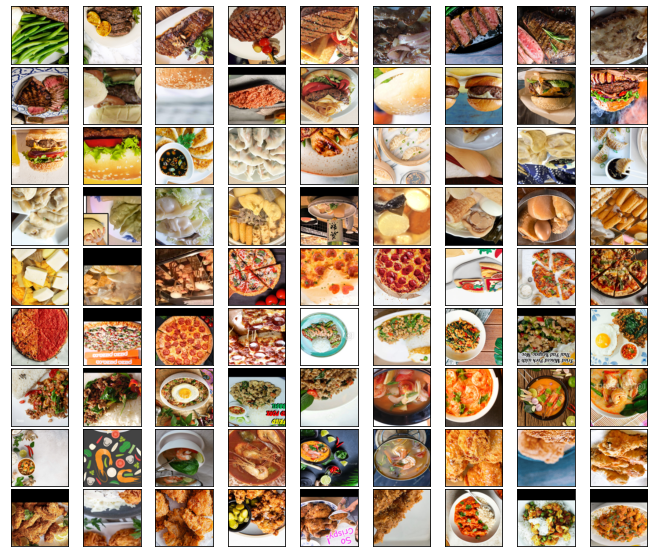

In [203]:
data_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=1.0),
                    transforms.RandomVerticalFlip(p=1.0)
])

dataset_horizontalVerticalFlip = datasets.ImageFolder(root=dataset_root_dir, transform=data_transform)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  plt.imshow(dataset_horizontalVerticalFlip[i * 10][0])

In [382]:
data_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=1.0),
                    transforms.RandomVerticalFlip(p=1.0)
])

train_dataset_horizontalVerticalFlip = MyDataset(train_dataset_initial, data_transform)

Merge all modified training dataset

In [383]:
train_dataset_noTransform = MyDataset(train_dataset_initial)

training_dataset_total = (train_dataset_noTransform + 
                          train_dataset_randomResizeCrop + 
                          train_dataset_randomResizeCropPaddingOne + 
                          train_dataset_randomResizeCropPaddingTwo +
                          train_dataset_randomResizeCropPaddingThree +
                          train_dataset_randomResizeCropPaddingFour +
                          train_dataset_randomResizeCropPaddingFive + 
                          train_dataset_randomResizeCropPaddingSix +
                          train_dataset_randomResizeCropPaddingSeven +
                          train_dataset_randomResizeCropPaddingEight +
                          train_dataset_horizontalFlip +
                          train_dataset_verticalFlip +
                          train_dataset_horizontalVerticalFlip +
                          train_dataset_horizontalFlipCrop)

# training_dataset_total = (train_dataset_noTransform + 
#                           train_dataset_randomResizeCrop + 
#                           train_dataset_randomResizeCropPaddingOne + 
#                           train_dataset_randomResizeCropPaddingTwo +
#                           train_dataset_horizontalFlip)

training_dataset_final = []

for imageTensor, label in training_dataset_total:
  # imageTensor = imageTensor.to('cpu').detach().numpy().copy().transpose(2, 1, 0)
  # imageTensor = torch.from_numpy(imageTensor.astype(np.float32)).clone()
  training_dataset_final.append([imageTensor, label])

# 3. Implementation of Convolutional Neural Network (CNN)

### 3.1. define layers of CNN

In [350]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

class Conv(nn.Module):
    def __init__(self, filter_shape, function=lambda x: x, stride=(1, 1), padding=0):
        super().__init__()
        # Heの初期値
        fan_in = filter_shape[1] * filter_shape[2] * filter_shape[3]
        # filter_shape: (出力チャンネル数)x(入力チャンネル数)x(縦の次元数)x(横の次元数)
        fan_out = filter_shape[0] * filter_shape[2] * filter_shape[3]

        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/fan_in),
                        size=filter_shape
                    ).astype('float32')))

        # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.b = nn.Parameter(torch.tensor(np.zeros((filter_shape[0]), dtype='float32')))

        self.function = function
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        u = F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding)
        return self.function(u)

class Pooling(nn.Module):
    def __init__(self, ksize=(2, 2), stride=(2, 2), padding=0):
        super().__init__()
        self.ksize = ksize
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=self.ksize, stride=self.stride, padding=self.padding)

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size()[0], -1)

class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # He Initialization
        # in_dim: 入力の次元数、out_dim: 出力の次元数
               
        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))

        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)

class Activation(nn.Module):
    def __init__(self, function=lambda x: x):
        super().__init__()
        self.function = function

    def __call__(self, x):
        return self.function(x)

def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [384]:
conv_net = nn.Sequential(
    # Conv((32, 3, 3, 3)),     # 32x32x3 -> 30x30x32
    Conv((32, 3, 11, 11)),      # 100x100x3 -> 90x90x32
    BatchNorm((32, 90, 90)),
    Activation(F.relu),
    Pooling((2, 2)),                  # 90x90x32 -> 45x45x32
    Conv((64, 32, 10, 10)),     # 45x45x32 -> 36x36x64
    BatchNorm((64, 36, 36)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 36x36x64 -> 18x18x64
    Conv((128, 64, 15, 15)),           # 18x18x64 -> 4x4x128
    BatchNorm((128, 4, 4)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 4x4x128 -> 2x2x128
    Flatten(),
    Dense(2*2*128, 256, F.relu),
    Dense(256, 10)
)

# conv_net = nn.Sequential(
#     # Conv((32, 3, 3, 3)),     # 32x32x3 -> 30x30x32
#     Conv((32, 3, 21, 21)),      # 100x100x3 -> 80x80x32
#     BatchNorm((32, 80, 80)),
#     Activation(F.relu),
#     Pooling((2, 2)),                  # 80x80x32 -> 40x40x32
#     Conv((64, 32, 11, 11)),     # 40x40x32 -> 30x30x64
#     BatchNorm((64, 30, 30)),
#     Activation(F.relu),
#     Pooling((2, 2)),                 # 30x30x64 -> 15x15x64
#     Conv((128, 64, 12, 12)),           # 18x18x64 -> 4x4x128
#     BatchNorm((128, 4, 4)),
#     Activation(F.relu),
#     Pooling((2, 2)),                 # 4x4x128 -> 2x2x128
#     Flatten(),
#     Dense(2*2*128, 256, F.relu),
#     Dense(256, 10)
# )

batch_size = 50
n_epochs = 50
lr = 0.01
device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)

In [385]:
dataloader_train = torch.utils.data.DataLoader(
    training_dataset_final,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

### 3.2. training

In [386]:
training_accuracy = []
validation_accuracy = []
lr = 0.01

for epoch in range(n_epochs):
    completeness = epoch / n_epochs
    if completeness < 0.25:
      lr = 0.01
    elif completeness < 0.5:
      lr = 0.005
    elif completeness < 0.75:
      lr = 0.003
    else:
      lr = 0.001

    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

    training_accuracy.append(acc_train/n_train)
    validation_accuracy.append(acc_val/n_val)

EPOCH: 0, Train [Loss: 1.960, Accuracy: 0.328], Valid [Loss: 2.002, Accuracy: 0.316]
EPOCH: 1, Train [Loss: 1.535, Accuracy: 0.461], Valid [Loss: 1.934, Accuracy: 0.337]
EPOCH: 2, Train [Loss: 1.226, Accuracy: 0.574], Valid [Loss: 1.908, Accuracy: 0.459]
EPOCH: 3, Train [Loss: 0.984, Accuracy: 0.664], Valid [Loss: 1.951, Accuracy: 0.439]
EPOCH: 4, Train [Loss: 0.726, Accuracy: 0.756], Valid [Loss: 1.935, Accuracy: 0.510]
EPOCH: 5, Train [Loss: 0.597, Accuracy: 0.800], Valid [Loss: 2.267, Accuracy: 0.520]
EPOCH: 6, Train [Loss: 0.481, Accuracy: 0.842], Valid [Loss: 2.124, Accuracy: 0.439]
EPOCH: 7, Train [Loss: 0.431, Accuracy: 0.857], Valid [Loss: 2.090, Accuracy: 0.551]
EPOCH: 8, Train [Loss: 0.322, Accuracy: 0.896], Valid [Loss: 2.418, Accuracy: 0.510]
EPOCH: 9, Train [Loss: 0.292, Accuracy: 0.904], Valid [Loss: 2.388, Accuracy: 0.582]
EPOCH: 10, Train [Loss: 0.265, Accuracy: 0.916], Valid [Loss: 2.589, Accuracy: 0.571]
EPOCH: 11, Train [Loss: 0.196, Accuracy: 0.938], Valid [Loss: 2.

### 3.4. test

In [387]:
conv_net.eval()

t_pred = []
for x, t in dataloader_test:

    x = x.to(device)

    # 順伝播
    y = conv_net.forward(x)

    # モデルの出力を予測値のスカラーに変換
    pred = y.argmax(1).tolist()

    t_pred.extend(pred)


In [388]:
conv_net.eval()
n_val = 0
acc_val = 0
losses_test = []
for x, t in dataloader_test:
    n_val += t.size()[0]

    x = x.to(device)  # テンソルをGPUに移動

    t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

    t = t.to(device)
    t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

    y = conv_net.forward(x)  # 順伝播

    loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

    pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

    acc_val += (pred == t).float().sum().item()
    losses_test.append(loss.tolist())

print('Test [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
    np.mean(losses_test),
    acc_val/n_val
))

Test [Loss: 2.929, Accuracy: 0.570]


(0.0, 1.0)

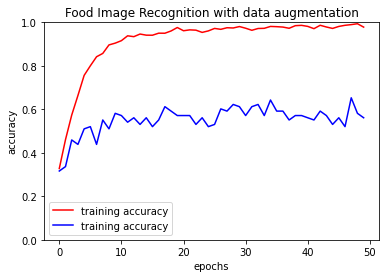

In [389]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.arange(50), training_accuracy, color="r", label="training accuracy")
plt.plot(np.arange(50), validation_accuracy, color="b", label="training accuracy")
plt.legend()
plt.title("Food Image Recognition with data augmentation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1)